In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import (
    accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef,
    classification_report, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay
)

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git # get the data here
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 32.66 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
dataset_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
def get_raw_data(filepath):
    with open(filepath) as f:
        return f.readlines()

In [ ]:
# Load the data
train_data = get_raw_data(dataset_dir + 'train.txt')

In [ ]:
import os

In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# View the first 20 lines from the dataset text file
train_data[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
# %%
def preprocess_raw_data(filepath):
    raw_data = get_raw_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    for line in raw_data:
        if line.startswith('###'): # check if current line is an abstract start (line -> ###[abstract_id]\n)
            abstract_id = int(line.replace('###', '').replace('\n', '')) # get abstract id
            abstract_data = ''

        elif line.isspace(): # check if current line is an abstract end (line -> '\n')
            abstract_data_split = abstract_data.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {} # store lines in dictionary
                target_text_split = abstract_line.split("\t") # split target label from text

                line_data["abstract_id"] = abstract_id # get abstract id
                line_data["line_id"] = f'{abstract_id}_{abstract_line_number}_{len(abstract_data_split)}' # create id for each line
                line_data["abstract_text"] = target_text_split[1] # get target text and lower it
                line_data["line_number"] = abstract_line_number # get line number in the abstract
                line_data["total_lines"] = len(abstract_data_split) # get total count for abstract lines (counter starts at 1)
                line_data['current_line'] = f'{abstract_line_number}_{len(abstract_data_split)}' # embed line_number & total_lines into one feature
                line_data["target"] = target_text_split[0] # get target label

                abstract_samples.append(line_data) # append line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line is a abstract text line (line -> [TARGET]\t[abstract_text])
            abstract_data += line

    return abstract_samples
# %%

In [ ]:
# Get train data from file and preprocess it
train_samples = preprocess_raw_data(dataset_dir + "train.txt")

In [ ]:
# Get dev/validation data from file and preprocess it
val_samples = preprocess_raw_data(dataset_dir + "dev.txt")

In [ ]:
# Get test data from file and preprocess it
test_samples = preprocess_raw_data(dataset_dir + "test.txt")

In [ ]:
train_count = len(train_samples)
val_count = len(val_samples)
test_count = len(test_samples)
total = train_count + val_count + test_count

In [ ]:
print(f'train samples count:\t\t{train_count}')
print(f'dev/validation samples count:\t{val_count}')
print(f'test samples count:\t\t{test_count}')

print(f'\ntotal samples:\t\t\t{total}')

train samples count:		180040
dev/validation samples count:	30212
test samples count:		30135

total samples:			240387


In [ ]:
# View first 10 abstracts from the train set
train_samples[:10]

[{'abstract_id': 24293578,
  'line_id': '24293578_0_12',
  'abstract_text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 12,
  'current_line': '0_12',
  'target': 'OBJECTIVE'},
 {'abstract_id': 24293578,
  'line_id': '24293578_1_12',
  'abstract_text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12,
  'current_line': '1_12',
  'target': 'METHODS'},
 {'abstract_id': 24293578,
  'line_id': '24293578_2_12',
  'abstract_text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12,
  'cur

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
# View the first 20 samples in train_df
train_df.head(20)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24293578,24293578_0_12,To investigate the efficacy of @ weeks of dail...,0,12,0_12,OBJECTIVE
1,24293578,24293578_1_12,A total of @ patients with primary knee OA wer...,1,12,1_12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,2_12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,3_12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,4_12,METHODS
5,24293578,24293578_5_12,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,12,5_12,METHODS
6,24293578,24293578_6_12,There was a clinically relevant reduction in t...,6,12,6_12,RESULTS
7,24293578,24293578_7_12,The mean difference between treatment arms ( @...,7,12,7_12,RESULTS
8,24293578,24293578_8_12,"Further , there was a clinically relevant redu...",8,12,8_12,RESULTS
9,24293578,24293578_9_12,These differences remained significant at @ we...,9,12,9_12,RESULTS


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<ipython-input-18-e65c13686a52>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=train_distribution.values,
<ipython-input-18-e65c13686a52>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=val_distribution.values,
<ipython-input-18-e65c13686a52>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


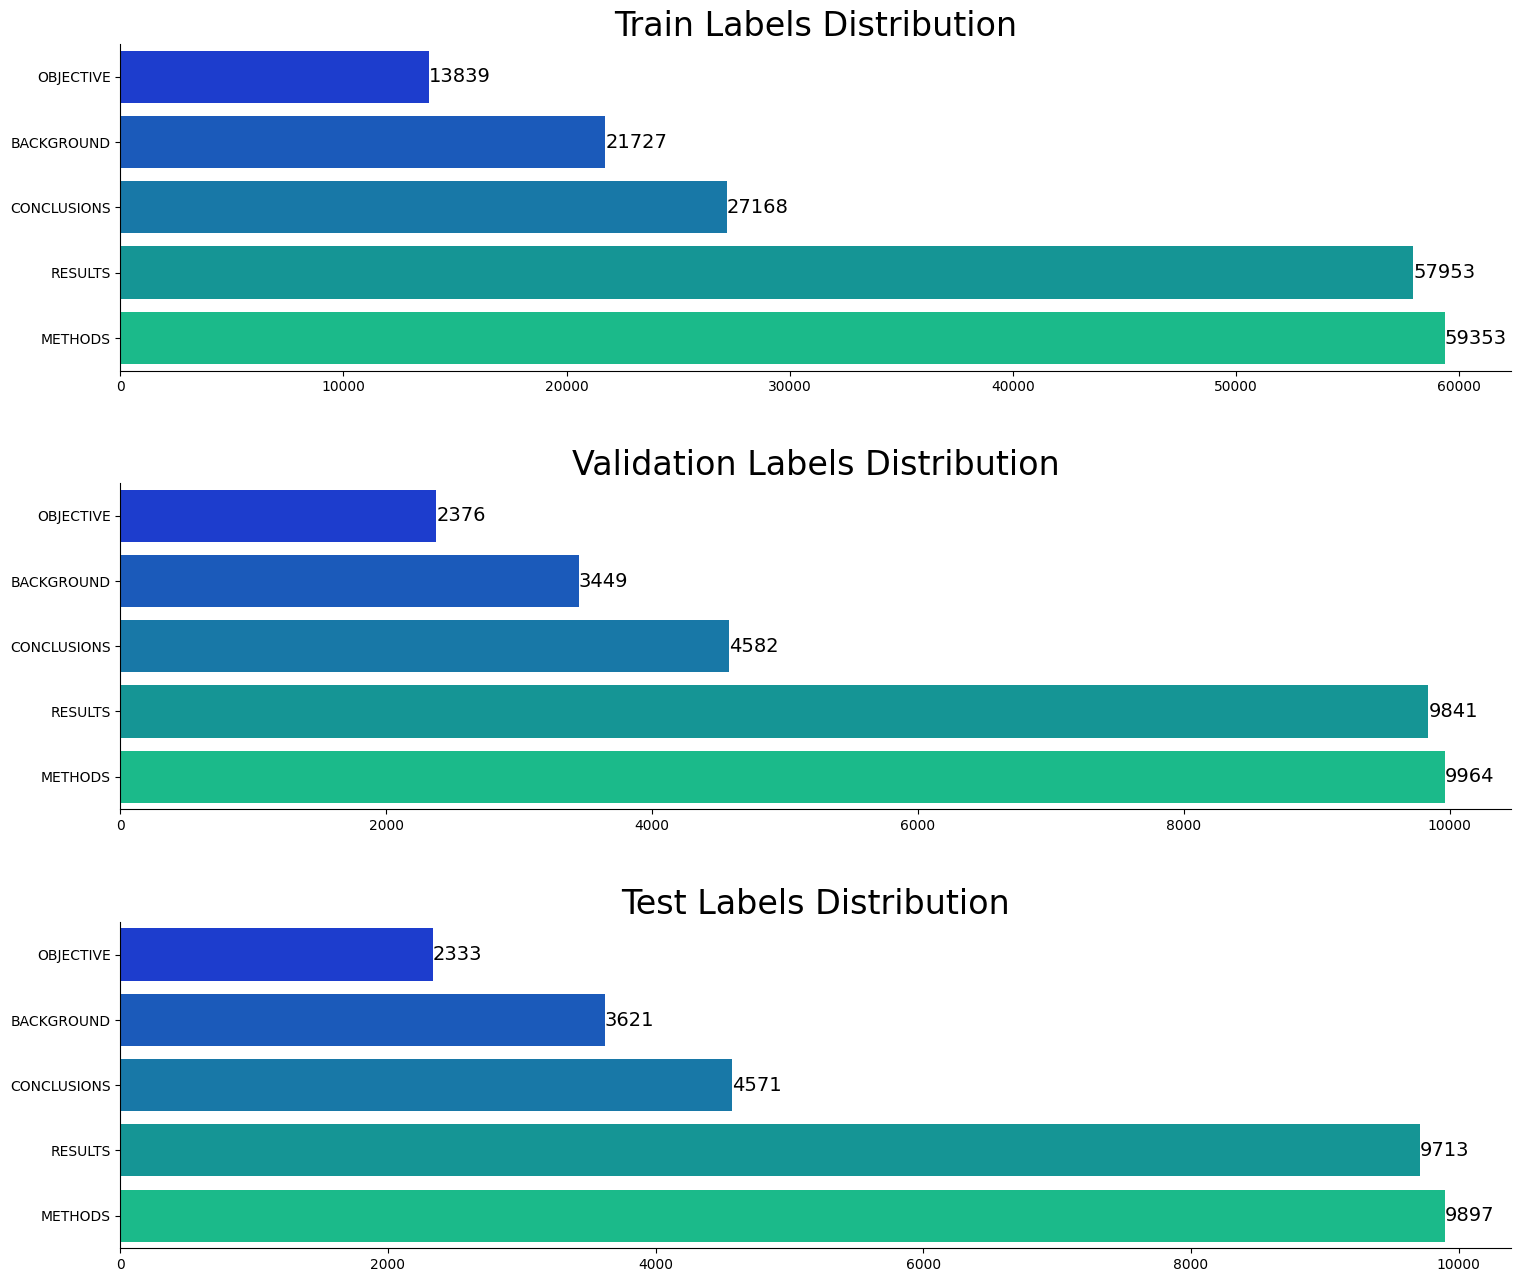

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 14))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)
sns.despine();

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=24)
train_distribution = train_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h", palette=sns.color_palette("winter", 5),
            ax=ax1);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=24)
val_distribution = val_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h", palette=sns.color_palette("winter", 5),
            ax=ax2);
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=24)
test_distribution = test_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(
    x=test_distribution.values,
    y=list(test_distribution.keys()),
    orient="h", palette=sns.color_palette("winter", 5),
    ax=ax3);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["abstract_text"].tolist()
val_sentences = val_df["abstract_text"].tolist()
test_sentences = test_df["abstract_text"].tolist()
# %%
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

print(f'Train samples count:\t\t{train_sentences_count}')
print(f'Dev/Validation sample count:\t{val_sentences_count}')
print(f'Test sample count:\t\t{test_sentences_count}')
print(f'Total samples:\t\t\t{total_sentences_count}')

Train samples count:		180040
Dev/Validation sample count:	30212
Test sample count:		30135
Total samples:			240387


In [ ]:
# View first 5 lines of train sentences
train_sentences[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
# %%
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [ ]:
train_df["target"][0]

'OBJECTIVE'

In [ ]:
# inspect one hot encoded targets
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
label_encoder = LabelEncoder()
# %%
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [ ]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 5
Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


In [ ]:
line_one_hot_encoder = OneHotEncoder(sparse_output=False)
# %%

train_lines_encoded = line_one_hot_encoder.fit_transform(train_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
val_lines_encoded = line_one_hot_encoder.transform(val_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
test_lines_encoded = line_one_hot_encoder.transform(test_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
# %%
test_lines_encoded.shape

(30135, 460)

In [ ]:
def apply_smoothing(line_one_hot, esp=0.01):
    return np.abs(line_one_hot - esp)

In [ ]:
def revert_smoothing(line_one_hot_smooth, esp=0.01):
    unsmooth = line_one_hot_smooth

    unsmooth[unsmooth>esp] = 1.0
    unsmooth[unsmooth<=esp] = 0.0

    return unsmooth

In [ ]:
# Only apply smoothing to train lines feature
train_lines_encoded = apply_smoothing(train_lines_encoded)

In [ ]:
def create_pipeline(features, labels, batch_size=32, shuffle=False, cache=False, prefetch=False) -> tf.data.Dataset:
    '''
    Generates an input pipeline using the tf.data API for training and inference.

    @params
        - features: (tuple) -> tuple containing the feature data
        - labels: (tf.Tensor | np.ndarray, default=None) -> target data related to the feature data
        - batch_size: (int) -> size for batched (default=32)
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (bool) -> condition for caching data, data is cached in memory when True (default=False)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)

    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''

    AUTOTUNE = tf.data.AUTOTUNE

    # Create dataset with features and labels
    ds = tf.data.Dataset.from_tensor_slices((features, labels))

    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Do this if the data is small enough to fit in memory!!!
    if cache:
        ds = ds.cache(buffer_size=AUTOTUNE)

    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the dataset
    return ds

In [ ]:
BATCH_SIZE = 32

# Create preprocessed training dataset
train_features = (train_sentences, train_lines_encoded.astype(np.float32))
train_labels = train_labels_one_hot.astype(np.float32)

# Create preprocessed train input data pipeline
train_ds = create_pipeline(
    train_features, train_labels,
    batch_size=BATCH_SIZE, shuffle=True,
    cache=False, prefetch=True)
# %%
# Create preprocessed validation dataset
val_features = (val_sentences, val_lines_encoded.astype(np.float32))
val_labels = val_labels_one_hot.astype(np.float32)

# Create preprocessed validation input data pipeline
val_ds = create_pipeline(val_features, val_labels,
                         batch_size=BATCH_SIZE, shuffle=False,
                         cache=False, prefetch=True)
# %%
# Create preprocessed test dataset
test_features = (test_sentences, test_lines_encoded.astype(np.float32))
test_labels = test_labels_one_hot.astype(np.float32)

# Create preprocessed test input data pipeline
test_ds = create_pipeline(test_features, test_labels,
                          batch_size=BATCH_SIZE, shuffle=False,
                          cache=False, prefetch=True)

In [ ]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


In [ ]:
from tensorflow import keras
import tensorflow as tf # Ensure tensorflow is imported
import tensorflow_hub as hub # Ensure tensorflow_hub is imported

# When using tensorflow_text, uncomment the line below to import the module
# import tensorflow_text as text

# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

# get Universal Sentence Encoder here
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

class SelfAttentionBlock(layers.Layer):

    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)

        self.query = layers.LSTM(self.units, activation=self.activation,
                                 kernel_initializer=self.kernel_initializer,
                                 return_sequences=True, name=f'block_query_lstm')

        self.value = layers.LSTM(self.units, activation=self.activation,
                                 kernel_initializer=self.kernel_initializer, go_backwards=True,
                                 return_sequences=True, name=f'block_value_lstm')

        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')


    def __call__(self, x):
        # Expand dimensions for LSTMs
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)

        # Generate LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)

        # Apply self-attention to LSTM
        block_attention = self.attention([block_query, block_value])

        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)

        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)

        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])

        return block_residual


def build_model():
    # Model Inputs
    #------------
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')
    # Ensure the shape is passed as a tuple
    abstract_current_line = layers.Input(shape=(460,), dtype=tf.float32, name='abstract_current_line')

    # Define Layer Initializer
    #------------
    initializer = tf.keras.initializers.GlorotNormal()

    # Text Embedding - Process on CPU
    #------------
    # Wrap the encoder call in a Lambda layer and explicitly place it on CPU
    # to avoid XLA issues with string inputs on GPU.
    with tf.device('/cpu:0'):
        abstract_embedding = layers.Lambda(lambda x: encoder(x), output_shape=(512,), name='abstract_embedding')(abstract_input)

    # Self Attention Block Stream - Process subsequent layers on GPU if available
    #------------
    # The SelfAttentionBlock expects an embedding input, which is now a KerasTensor
    # resulting from the encoder. This should work as long as SelfAttentionBlock
    # is implemented using Keras layers and operations.
    # Note: The embedding tensor will be on the CPU if the device context was applied.
    # Subsequent layers can then potentially be moved to GPU for computation by TensorFlow.
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])

    # Current Line Stream
    #------------
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)

    # Concat Streams
    #------------
    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    # Output Layer
    #------------
    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input,
                                  abstract_current_line],
                          outputs=[output_layer], name="use_attention_model")

In [ ]:
# Build model
model = build_model()

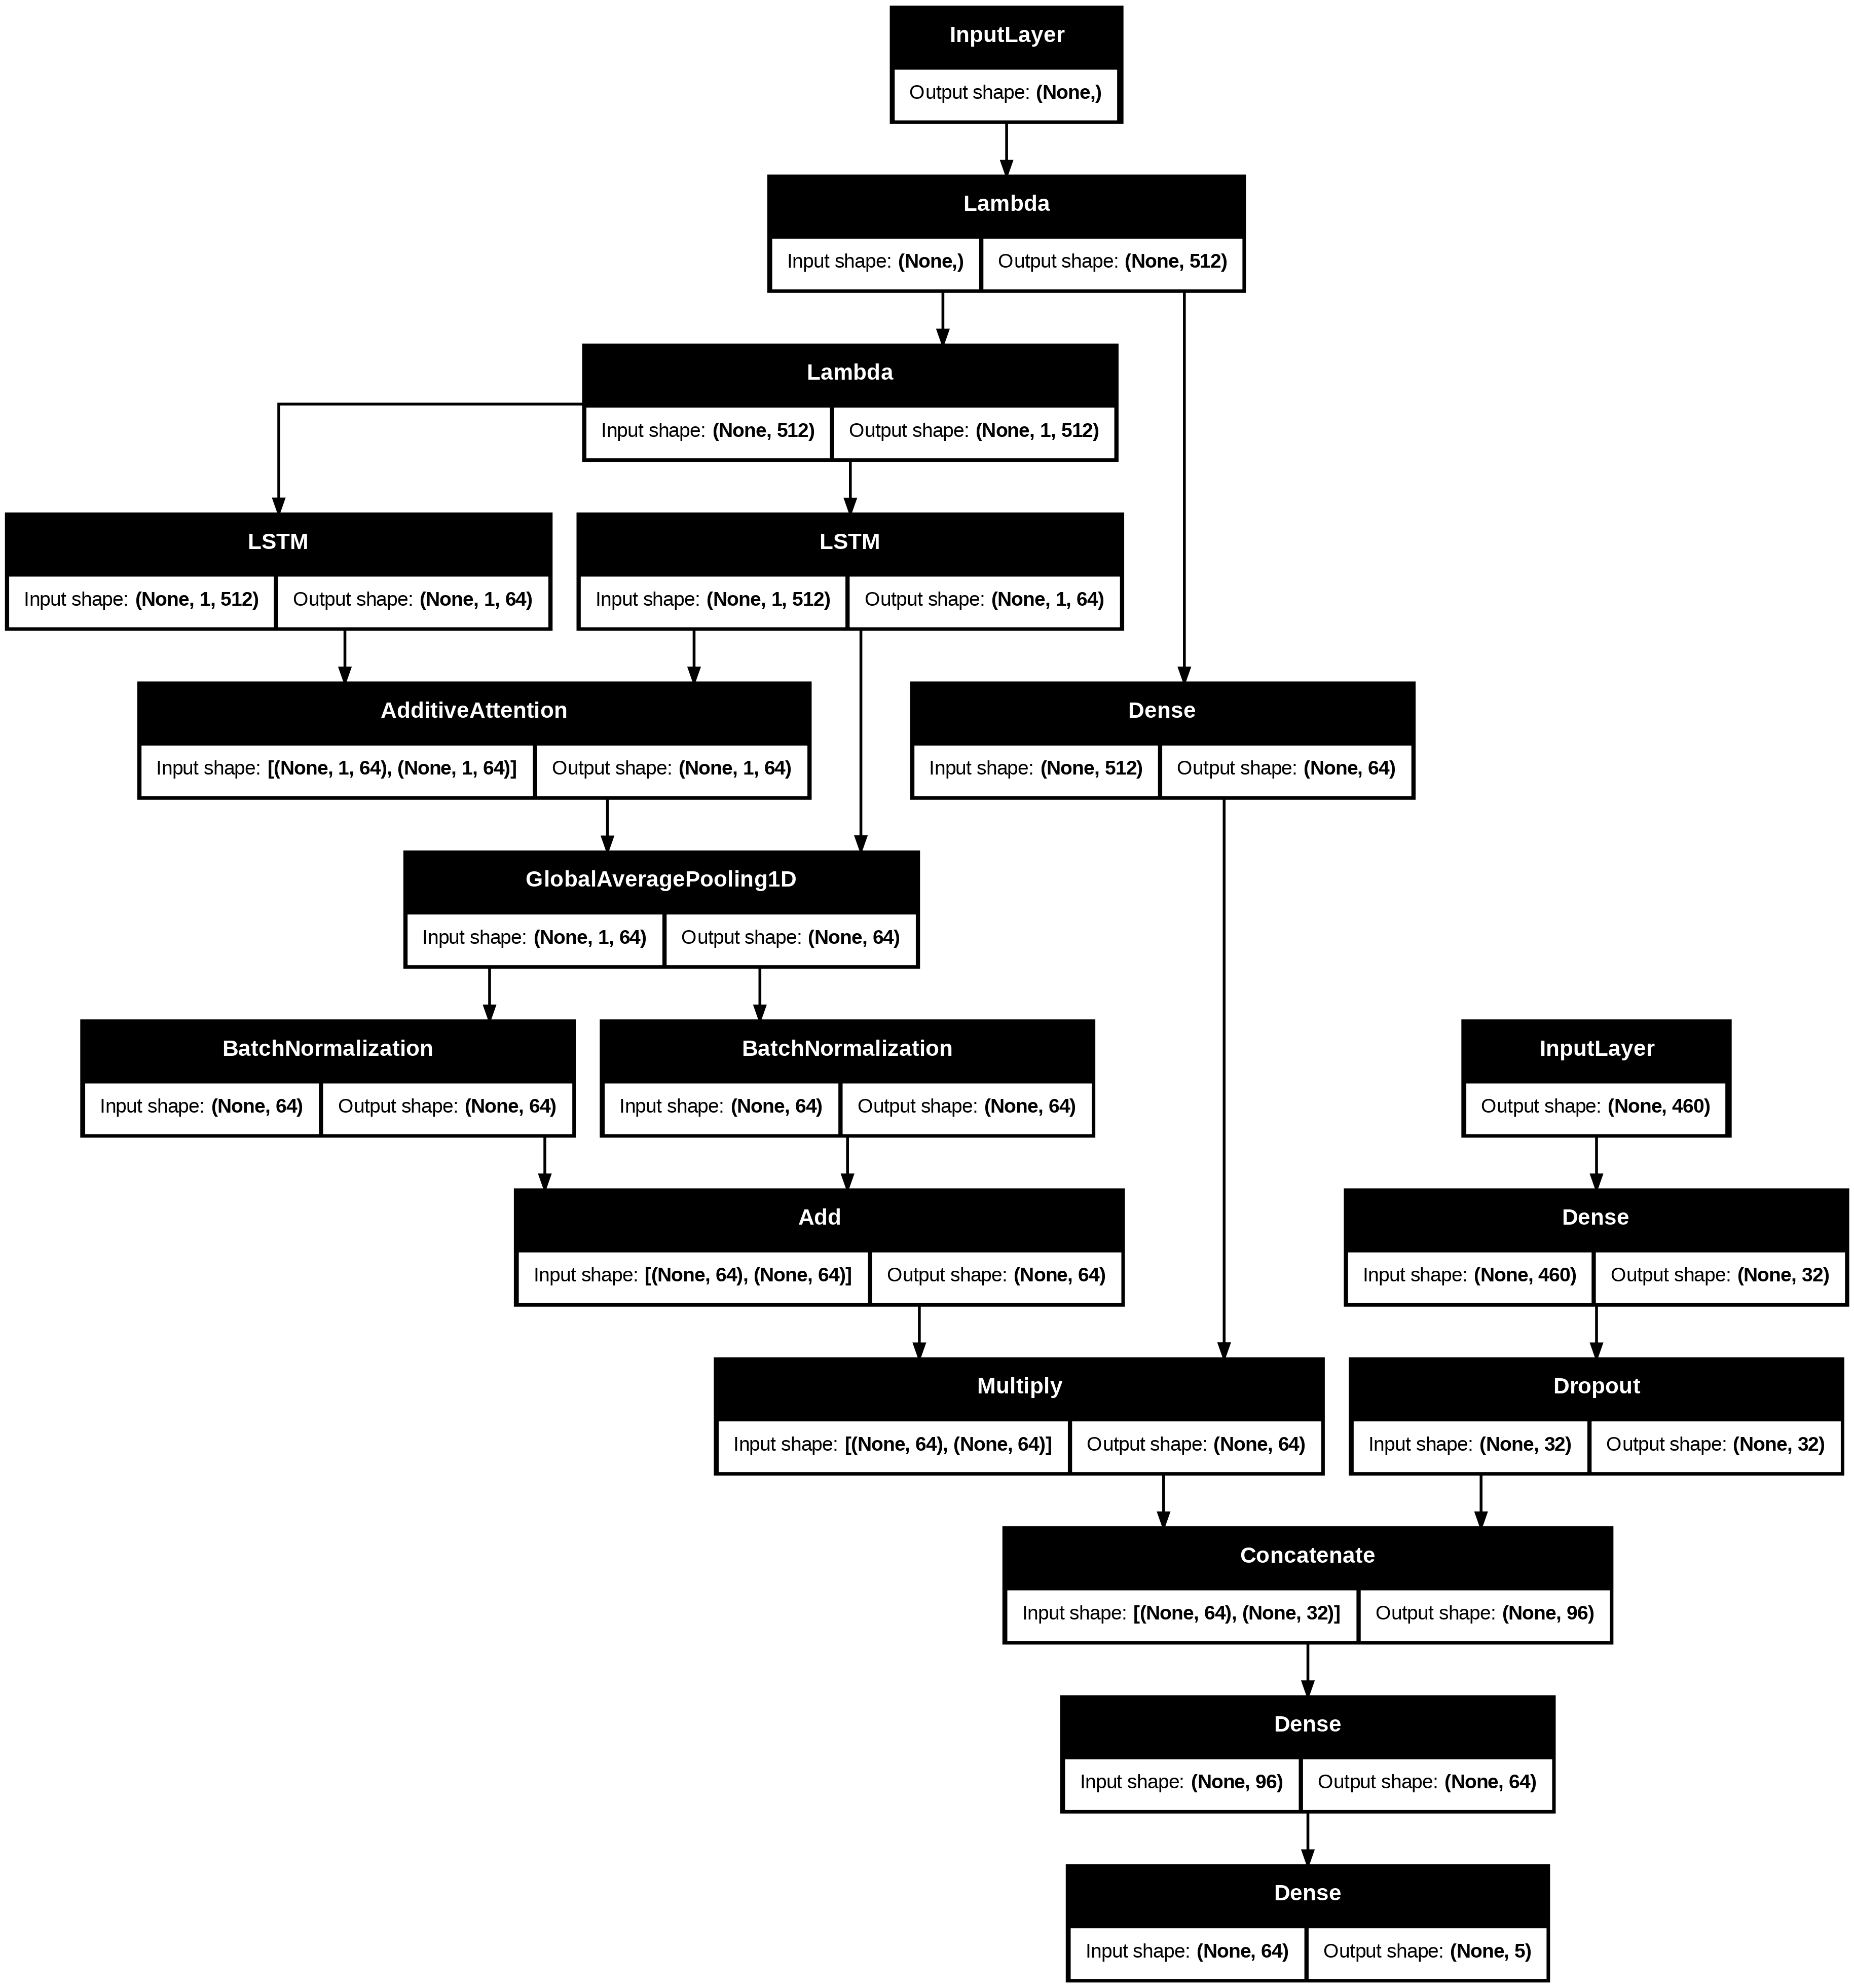

In [ ]:
# Explore model visually
plot_model(
    model,
    show_shapes=True,
    expand_nested=True
)

In [ ]:
def train_model(model, num_epochs, callbacks_list, tf_train_data,
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data.

        @params
        - model: (tf.keras.model) -> model to be trained
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)

        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''

    model_history = {}

    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)

    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = 10
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [ ]:
tf.random.set_seed(42)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model.name}.')
print(f'Train on {train_sentences_count} samples, validate on {val_sentences_count} samples.')
print('----------------------------------')

model_history = train_model(
    model, EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)

Training use_attention_model.
Train on 180040 samples, validate on 30212 samples.
----------------------------------
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5627/5627 ━━━━━━━━━━━━━━━━━━━━ 152s 25ms/step - accuracy: 0.7947 - loss: 0.7978 - val_accuracy: 0.8722 - val_loss: 0.6516 - learning_rate: 0.0010
Epoch 2/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 145s 26ms/step - accuracy: 0.8711 - loss: 0.6458 - val_accuracy: 0.8733 - val_loss: 0.6441 - learning_rate: 0.0010
Epoch 3/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 142s 25ms/step - accuracy: 0.8814 - loss: 0.6263 - val_accuracy: 0.8728 - val_loss: 0.6405 - learning_rate: 0.0010
Epoch 4/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 144s 26ms/step - accuracy: 0.8886 - loss: 0.6121 - val_accuracy: 0.8720 - val_loss: 0.6425 - learning_rate: 0.0010
Epoch 5/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8947 - loss: 0.6011
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 197s 25ms/step - accuracy: 0.8947 - loss: 0.6011 - val_accuracy: 0.8696 - val_loss: 0.6497 - learning_rate: 0.0010
Epoch 6/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 153s 27ms/step - accuracy: 0.

In [ ]:
# evaluate the model on the test data to see how it performs
model.evaluate(test_ds)

942/942 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8673 - loss: 0.6536


[0.6490180492401123, 0.8689231872558594]

In [ ]:
# generate validation probabilities
val_probabilities = model.predict(val_ds, verbose=1)
val_probabilities

945/945 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step


array([[0.7652468 , 0.035576  , 0.02203006, 0.16572054, 0.01142652],
       [0.7637125 , 0.01224239, 0.00520327, 0.20823656, 0.01060524],
       [0.41638184, 0.02534086, 0.09541564, 0.44129008, 0.02157154],
       ...,
       [0.02005093, 0.02435406, 0.01538766, 0.02003561, 0.9201718 ],
       [0.03258813, 0.7887584 , 0.01459168, 0.02996413, 0.13409771],
       [0.04340291, 0.922841  , 0.00347283, 0.02696024, 0.00332302]],
      dtype=float32)

In [ ]:
# generate validation predictions with argmax
val_predictions = tf.argmax(val_probabilities, axis=1)
val_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# generate test probabilities
test_probabilities = model.predict(test_ds, verbose=1)
test_probabilities

942/942 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step


array([[0.38692823, 0.03543545, 0.01980208, 0.54003245, 0.01780183],
       [0.25137782, 0.04190267, 0.39541712, 0.23181096, 0.07949135],
       [0.02030249, 0.0246332 , 0.86100286, 0.0374561 , 0.05660535],
       ...,
       [0.02077754, 0.0409209 , 0.02566315, 0.0204557 , 0.8921827 ],
       [0.01856192, 0.19260003, 0.02295959, 0.03976059, 0.72611785],
       [0.01187527, 0.957448  , 0.0017897 , 0.01940623, 0.00948088]],
      dtype=float32)

In [ ]:
# generate test predictions with argmax
test_predictions = tf.argmax(test_probabilities, axis=1)
test_predictions

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [ ]:
def plot_training_curves(history):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

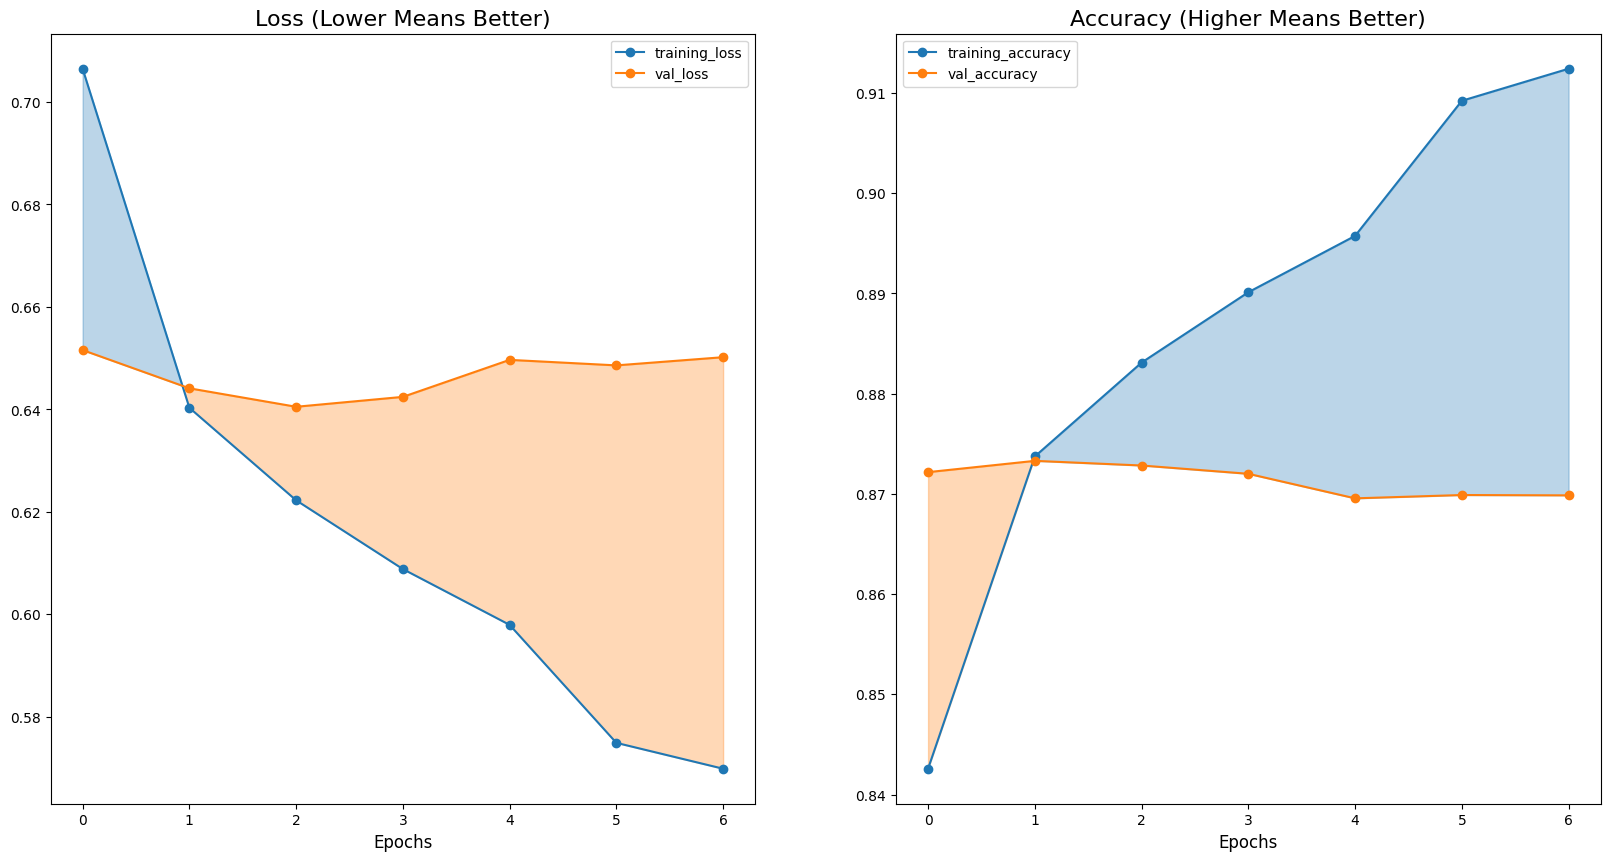

In [ ]:
# plot model training history
plot_training_curves(model_history)

In [ ]:
# Generate validation classification report
print(classification_report(val_labels_encoded, val_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.70      0.86      0.77      3449
 CONCLUSIONS       0.90      0.92      0.91      4582
     METHODS       0.92      0.91      0.91      9964
   OBJECTIVE       0.77      0.52      0.62      2376
     RESULTS       0.90      0.90      0.90      9841

    accuracy                           0.87     30212
   macro avg       0.84      0.82      0.82     30212
weighted avg       0.87      0.87      0.87     30212



In [ ]:
# Generate test classification report
print(classification_report(test_labels_encoded, test_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.72      0.86      0.78      3621
 CONCLUSIONS       0.90      0.92      0.91      4571
     METHODS       0.91      0.91      0.91      9897
   OBJECTIVE       0.76      0.52      0.61      2333
     RESULTS       0.90      0.89      0.90      9713

    accuracy                           0.87     30135
   macro avg       0.84      0.82      0.82     30135
weighted avg       0.87      0.87      0.87     30135



In [ ]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):

    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    top_3_accuracy = round(top_k_accuracy_score(y_true, y_probabilities, k=3), 5)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_labels_encoded,
                                                                                 test_predictions,
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)
    model_matthews_corrcoef = round(matthews_corrcoef(y_true, y_pred), 5)

    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')
    print('=============================================')

    return

In [ ]:
generate_preformance_scores(val_labels_encoded, val_predictions, val_probabilities)


Performance Metrics:

accuracy_score:		0.87283

_____________________________________________
top_3_accuracy_score:	0.9949

_____________________________________________
precision_score:	0.86969

_____________________________________________
recall_score:		0.86892

_____________________________________________
f1_score:		0.86674

_____________________________________________
matthews_corrcoef:	0.82947



In [ ]:
generate_preformance_scores(test_labels_encoded, test_predictions, test_probabilities)


Performance Metrics:

accuracy_score:		0.86892

_____________________________________________
top_3_accuracy_score:	0.99433

_____________________________________________
precision_score:	0.86969

_____________________________________________
recall_score:		0.86892

_____________________________________________
f1_score:		0.86674

_____________________________________________
matthews_corrcoef:	0.82441



In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=11):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size},
        fmt='d',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)

    # Plot confusion matrix
    plt.show()

    return

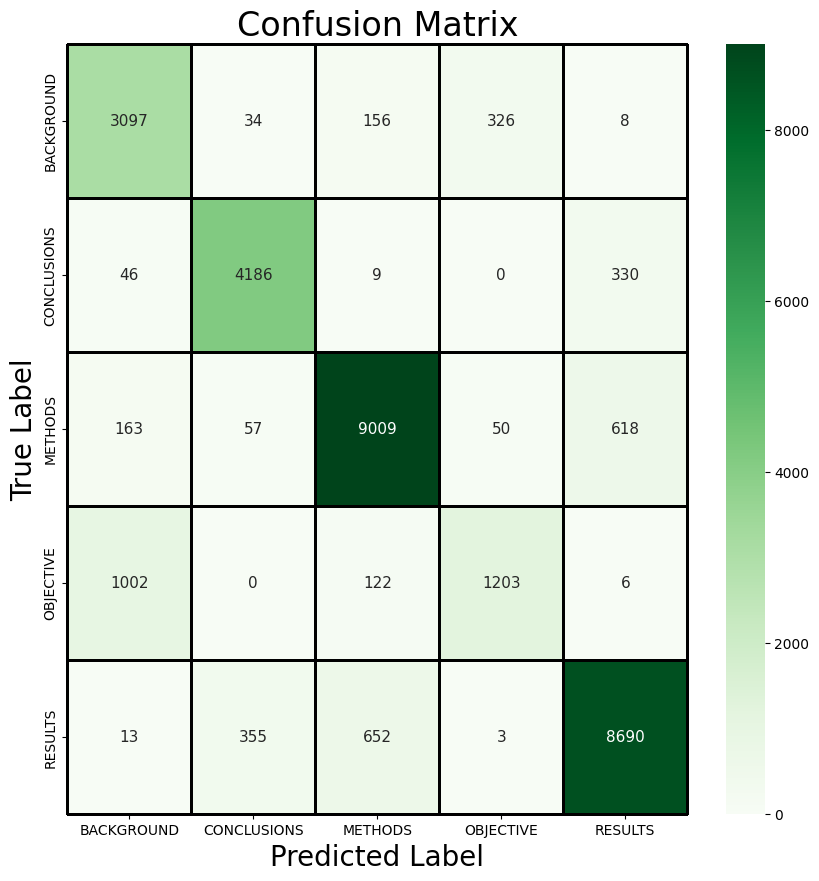

In [ ]:
# View Confusion Matrix
plot_confusion_matrix(
    test_labels_encoded,
    test_predictions,
    figsize=(10, 10),
    classes=list(class_names))

In [ ]:
test_df

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,0_9,BACKGROUND
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,1_9,RESULTS
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,2_9,RESULTS
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,3_9,RESULTS
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,4_9,RESULTS
...,...,...,...,...,...,...,...
30130,24261927,24261927_13_18,There was a statistically significant between-...,13,18,13_18,RESULTS
30131,24261927,24261927_14_18,There were no statistically significant betwee...,14,18,14_18,RESULTS
30132,24261927,24261927_15_18,There was no significant association between s...,15,18,15_18,RESULTS
30133,24261927,24261927_16_18,No adverse effects were reported .,16,18,16_18,RESULTS


In [ ]:
# Get top 3 predictions
top_3_values, top_3_indices = tf.nn.top_k(test_probabilities, k=3)

In [ ]:
%%time
# copy test_df
test_pred_df = test_df.copy()

# add best predictions
test_pred_df['prediction'] = [class_names[_] for _ in top_3_indices[:, 0]]
test_pred_df['probability'] = list(top_3_values[:, 0].numpy())

# add 2nd best predictions
test_pred_df['prediction_2'] = [class_names[_] for _ in top_3_indices[:, 1]]
test_pred_df['probability_2'] = list(top_3_values[:, 1].numpy())

# add 3rd best predictions
test_pred_df['prediction_3'] = [class_names[_] for _ in top_3_indices[:, 2]]
test_pred_df['probability_3'] = list(top_3_values[:, 2].numpy())

CPU times: user 38.9 s, sys: 95.2 ms, total: 39 s
Wall time: 49.8 s


In [ ]:
test_pred_df

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target,prediction,probability,prediction_2,probability_2,prediction_3,probability_3
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,0_9,BACKGROUND,OBJECTIVE,0.540032,BACKGROUND,0.386928,CONCLUSIONS,0.035435
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,1_9,RESULTS,METHODS,0.395417,BACKGROUND,0.251378,OBJECTIVE,0.231811
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,2_9,RESULTS,METHODS,0.861003,RESULTS,0.056605,OBJECTIVE,0.037456
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,3_9,RESULTS,METHODS,0.679576,RESULTS,0.233573,CONCLUSIONS,0.034595
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,4_9,RESULTS,RESULTS,0.825407,METHODS,0.097857,BACKGROUND,0.027113
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30130,24261927,24261927_13_18,There was a statistically significant between-...,13,18,13_18,RESULTS,RESULTS,0.892897,METHODS,0.029259,CONCLUSIONS,0.029097
30131,24261927,24261927_14_18,There were no statistically significant betwee...,14,18,14_18,RESULTS,RESULTS,0.915175,CONCLUSIONS,0.040687,OBJECTIVE,0.019408
30132,24261927,24261927_15_18,There was no significant association between s...,15,18,15_18,RESULTS,RESULTS,0.892183,CONCLUSIONS,0.040921,METHODS,0.025663
30133,24261927,24261927_16_18,No adverse effects were reported .,16,18,16_18,RESULTS,RESULTS,0.726118,CONCLUSIONS,0.192600,OBJECTIVE,0.039761


In [ ]:
def view_prediction(pred_df, sample_index):
    sample = pred_df.iloc[sample_index]

    print('====================================================')
    print(f'id:\t\t{sample.abstract_id}')
    print('____________________________________________________')
    print(f'text:\n\n{sample.abstract_text}')
    print('____________________________________________________')
    print(f'current_line:\t{sample.current_line}')
    print('____________________________________________________')
    print(f'target:\t\t{sample.target}')
    print('____________________________________________________')
    print(f'predictions:\n')
    print(f'1: {sample.prediction}({sample.probability})')
    print(f'2: {sample["prediction_2"]}({sample["probability_2"]})')
    print(f'3: {sample["prediction_3"]}({sample["probability_3"]})')
    print('====================================================')

    return

In [ ]:
least_accurate = test_pred_df.loc[test_pred_df.target == test_pred_df.prediction].sort_values('probability', inplace=False)

In [ ]:
least_accurate.head(5).T

,8761,18760,2311,13373,16585
abstract_id,24947625,25494622,25108889,25102884,24811543
line_id,24947625_5_10,25494622_8_17,25108889_7_18,25102884_3_8,24811543_9_28
abstract_text,"This study will be the first Danish , randomis...",The physical activity intervention is framed a...,We did a secondary analysis that corrected for...,"During the treatment , we observed drugs ' abi...",The key outcome variables were peak trunk flex...
line_number,5,8,7,3,9
total_lines,10,17,18,8,28
current_line,5_10,8_17,7_18,3_8,9_28
target,CONCLUSIONS,METHODS,METHODS,METHODS,METHODS
prediction,CONCLUSIONS,METHODS,METHODS,METHODS,METHODS
probability,0.280999,0.283517,0.287491,0.308817,0.311536
prediction_2,BACKGROUND,CONCLUSIONS,RESULTS,BACKGROUND,BACKGROUND


In [ ]:
view_prediction(least_accurate, 0)

id:		24947625
____________________________________________________
text:

This study will be the first Danish , randomised , controlled study comparing conventional LRYGB with and without closure of the mesenteric defects .
____________________________________________________
current_line:	5_10
____________________________________________________
target:		CONCLUSIONS
____________________________________________________
predictions:

1: CONCLUSIONS(0.28099915385246277)
2: BACKGROUND(0.23276405036449432)
3: RESULTS(0.17397166788578033)


In [ ]:
view_prediction(least_accurate, 1)

id:		25494622
____________________________________________________
text:

The physical activity intervention is framed around self-determination theory placed within a broader behaviour change wheel framework .
____________________________________________________
current_line:	8_17
____________________________________________________
target:		METHODS
____________________________________________________
predictions:

1: METHODS(0.28351685404777527)
2: CONCLUSIONS(0.24680858850479126)
3: RESULTS(0.20848558843135834)


In [ ]:
most_inaccurate = test_pred_df.loc[test_pred_df.target != test_pred_df.prediction].sort_values('probability', inplace=False)

In [ ]:
most_inaccurate.head(5).T

,23023,26060,9085,15345,27125
abstract_id,25515217,25125229,24625034,24862977,24769601
line_id,25515217_7_14,25125229_2_10,24625034_13_17,24862977_2_8,24769601_9_14
abstract_text,"Our aims are to understand how , why , and for...",Two babies entered the randomised trial ; @ re...,Scores will be compared using a Student t-test...,We examined the changes in plasma nitrite conc...,Researchers asked questions about healthcare r...
line_number,7,2,13,2,9
total_lines,14,10,17,8,14
current_line,7_14,2_10,13_17,2_8,9_14
target,BACKGROUND,RESULTS,METHODS,OBJECTIVE,METHODS
prediction,CONCLUSIONS,METHODS,CONCLUSIONS,METHODS,CONCLUSIONS
probability,0.247316,0.272293,0.275049,0.277703,0.281255
prediction_2,METHODS,BACKGROUND,BACKGROUND,RESULTS,RESULTS


In [ ]:
view_prediction(most_inaccurate, 0)

id:		25515217
____________________________________________________
text:

Our aims are to understand how , why , and for whom the intervention produced the observed outcomes and to develop effective strategies for translation and dissemination .
____________________________________________________
current_line:	7_14
____________________________________________________
target:		BACKGROUND
____________________________________________________
predictions:

1: CONCLUSIONS(0.247315913438797)
2: METHODS(0.24502778053283691)
3: RESULTS(0.2288520634174347)


In [ ]:
wild_abstract_text = """The discovery of genetic loci associated with complex diseases has outpaced the elucidation of
mechanisms of disease pathogenesis. Here we conducted a genome-wide association study (GWAS)
for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of
predominantly European ancestry. We detected 241 associations, including 30 new loci. Cross-
ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci. We prioritized likely
causal variants using functionally informed fine-mapping, yielding 42 associations with less than
five variants in the 95% credible set. Similarity-based clustering suggested roles for early
developmental processes, cell cycle signaling and vascular cell migration and proliferation in the
pathogenesis of CAD. We prioritized 220 candidate causal genes, combining eight complementary
approaches, including 123 supported by three or more approaches. Using CRISPR–Cas9, we
experimentally validated the effect of an enhancer in MYO9B, which appears to mediate CAD risk by
regulating vascular cell motility. Our analysis identifies and systematically characterizes >250 risk
loci for CAD to inform experimental interrogation of putative causal mechanisms for CAD."""

In [ ]:
# view the abstract
print(wild_abstract_text)

The discovery of genetic loci associated with complex diseases has outpaced the elucidation of 
mechanisms of disease pathogenesis. Here we conducted a genome-wide association study (GWAS) 
for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of 
predominantly European ancestry. We detected 241 associations, including 30 new loci. Cross-
ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci. We prioritized likely 
causal variants using functionally informed fine-mapping, yielding 42 associations with less than 
five variants in the 95% credible set. Similarity-based clustering suggested roles for early 
developmental processes, cell cycle signaling and vascular cell migration and proliferation in the 
pathogenesis of CAD. We prioritized 220 candidate causal genes, combining eight complementary 
approaches, including 123 supported by three or more approaches. Using CRISPR–Cas9, we 
experimentally validated the effect of an enhancer

In [ ]:
wild_abstract_preprocessed = """The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .
Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .
We detected 241 associations, including 30 new loci .
Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .
We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .
Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .
We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by three or more approaches .
Using CRISPR–Cas9, we experimentally validated the effect of an enhancer in MYO9B, which appears to mediate CAD risk by regulating vascular cell motility .
Our analysis identifies and systematically characterizes >250 risk loci for CAD to inform experimental interrogation of putative causal mechanisms for CAD ."""

In [ ]:
# Split the abstract into it's lines as seen in the original paper
wild_texts = [_  for _ in wild_abstract_preprocessed.split('\n')]

# convert the list of texts line into a numpy array
wild_texts = np.array(wild_texts).reshape((len(wild_texts), 1))
wild_texts.shape

(9, 1)

In [ ]:
wild_texts

array([['The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .'],
       ['Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .'],
       ['We detected 241 associations, including 30 new loci . '],
       ['Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .'],
       ['We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .'],
       ['Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .'],
       ['We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by three or more approa

In [ ]:
# generate the combined feature current_line for the wild abstract
wild_current_lines = [f'{_}_{len(wild_texts)}' for _ in range(len(wild_texts))]
print(wild_current_lines)

['0_9', '1_9', '2_9', '3_9', '4_9', '5_9', '6_9', '7_9', '8_9']


In [ ]:
# one-hot encode the current_lines feature
wild_current_lines_transformed = line_one_hot_encoder.transform(np.array(wild_current_lines).reshape(-1, 1))
wild_current_lines_transformed.shape

(9, 460)

In [ ]:
# Split the abstract into it's lines as seen in the original paper
wild_texts = [_  for _ in wild_abstract_preprocessed.split('\n')]

# Convert the list of texts line into a TensorFlow tensor of type string
wild_texts_tensor = tf.constant(wild_texts, dtype=tf.string)

# generate the combined feature current_line for the wild abstract
wild_current_lines = [f'{_}_{len(wild_texts)}' for _ in range(len(wild_texts))]

# one-hot encode the current_lines feature
# Reshape to (-1, 1) is correct for OneHotEncoder
wild_current_lines_transformed = line_one_hot_encoder.transform(np.array(wild_current_lines).reshape(-1, 1))

# Use the TensorFlow tensor and the one-hot encoded lines in the predict call
wild_probabilities = model.predict((wild_texts_tensor, wild_current_lines_transformed), verbose=1)
wild_probabilities

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


array([[0.8209198 , 0.01054344, 0.00602082, 0.15490797, 0.00760784],
       [0.03204345, 0.01926333, 0.8845259 , 0.03976657, 0.02440072],
       [0.04054679, 0.05512708, 0.6199797 , 0.03145449, 0.252892  ],
       [0.02823743, 0.0297242 , 0.7792437 , 0.02295175, 0.1398429 ],
       [0.03834589, 0.04132067, 0.07365473, 0.03754874, 0.8091299 ],
       [0.02071003, 0.06347112, 0.6294302 , 0.04017721, 0.24621144],
       [0.04431929, 0.33536026, 0.16396935, 0.03883272, 0.41751832],
       [0.01486738, 0.8950756 , 0.02623454, 0.02162521, 0.04219737],
       [0.0116719 , 0.9528925 , 0.00615031, 0.01650742, 0.01277793]],
      dtype=float32)

In [ ]:
wild_texts_tensor

<tf.Tensor: shape=(9,), dtype=string, numpy=
array([b'The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .',
       b'Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .',
       b'We detected 241 associations, including 30 new loci . ',
       b'Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .',
       b'We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .',
       b'Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .',
       b'We prioritized 220 candidate causal genes, combining eight complementary approaches, includin

In [ ]:
# Use the TensorFlow tensor and the one-hot encoded lines in the predict call
wild_probabilities = model.predict((wild_texts_tensor, wild_current_lines_transformed), verbose=1)
wild_probabilities

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


array([[0.8209198 , 0.01054344, 0.00602082, 0.15490797, 0.00760784],
       [0.03204345, 0.01926333, 0.8845259 , 0.03976657, 0.02440072],
       [0.04054679, 0.05512708, 0.6199797 , 0.03145449, 0.252892  ],
       [0.02823743, 0.0297242 , 0.7792437 , 0.02295175, 0.1398429 ],
       [0.03834589, 0.04132067, 0.07365473, 0.03754874, 0.8091299 ],
       [0.02071003, 0.06347112, 0.6294302 , 0.04017721, 0.24621144],
       [0.04431929, 0.33536026, 0.16396935, 0.03883272, 0.41751832],
       [0.01486738, 0.8950756 , 0.02623454, 0.02162521, 0.04219737],
       [0.0116719 , 0.9528925 , 0.00615031, 0.01650742, 0.01277793]],
      dtype=float32)

In [ ]:
import numpy as np

def view_wild_prediction(wild_texts, wild_current_lines, wild_probabilities, class_labels=class_names):
    """
    Displays wild predictions in a human-friendly format.

    Parameters:
    - wild_texts (list[str]): List of raw input texts.
    - wild_current_lines (list[str]): List of additional textual context or metadata associated with each text.
    - wild_probabilities (np.array): An array of prediction probabilities generated by the model.
      This array is expected to have shape (num_examples, num_classes).
    - class_labels (list[str], optional): List of class names corresponding to the output indices.
      If provided, predictions will be shown with their class names.
    """
    # Check if predictions are probability distributions (e.g., for a classification task)
    # We assume that each prediction is an array over classes.
    predicted_classes = np.argmax(wild_probabilities, axis=1)

    for idx, (text, current_line, probs) in enumerate(zip(wild_texts, wild_current_lines, wild_probabilities)):
        predicted_class = predicted_classes[idx]
        probability = probs[predicted_class]
        # Use provided class labels or fallback to a generic label string
        label = class_labels[predicted_class] if class_labels is not None else f"Class {predicted_class}"

        'print(f"Example {idx+1}:")'
        print(f"Input Text       : {text}")
        print(f"Current Line     : {current_line}")
        print(f"Predicted Class  : {class_names}")
        print(f"Probabilities    : {probs}")
        print(f"Predicted Output : {label} (Probability: {probability:.2f})")
        print("-" * 60)

# Example usage:
# wild_texts = ["This is a sample text.", "Another example input."]
# wild_current_lines = ["Additional context 1", "Additional context 2"]
# wild_probabilities = np.array([[0.1, 0.8, 0.1], [0.3, 0.3, 0.4]])
# class_labels = ["Negative", "Neutral", "Positive"]
# view_wild_prediction(wild_texts, wild_current_lines, wild_probabilities, class_labels)


In [ ]:
view_wild_prediction(wild_texts, wild_current_lines, wild_probabilities)

Input Text       : The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .
Current Line     : 0_9
Predicted Class  : ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']
Probabilities    : [0.8209198  0.01054344 0.00602082 0.15490797 0.00760784]
Predicted Output : BACKGROUND (Probability: 0.82)
------------------------------------------------------------
Input Text       : Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .
Current Line     : 1_9
Predicted Class  : ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']
Probabilities    : [0.03204345 0.01926333 0.8845259  0.03976657 0.02440072]
Predicted Output : METHODS (Probability: 0.88)
------------------------------------------------------------
Input Text       : We detected 241 associations, including 30 new loci 

In [ ]:
def display_segemented_abstract(wild_texts, labels, color=False):
    colors = {
        'BACKGROUND': 34,     # blue
        'OBJECTIVE': 35,      # magenta
        'METHODS': 32,        # green
        'RESULTS': 33,        # yellow
        'CONCLUSIONS': 31     # red
    }

    segmented_abstract = ""

    for idx, (text_line, text_label) in enumerate(zip(wild_texts, labels)):
        if color:
            segmented_abstract += '\033[1;{}m{:<12s}\n{:<12s}\n\n'.format(colors[text_label], text_label, text_line)
        else:
            segmented_abstract += '{:<12s}\n {:<12s}\n'.format(text_label, text_line[0])

    return segmented_abstract

In [ ]:
wild_predictions = np.argmax(wild_probabilities, axis=1)
wild_labels = [class_names[_] for _ in wild_predictions]

In [ ]:
wild_segmented_abstract = display_segemented_abstract(wild_texts, wild_labels, color=True)
print(wild_segmented_abstract)

BACKGROUND  
The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .

METHODS     
Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .

METHODS     
We detected 241 associations, including 30 new loci . 

METHODS     
Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .

RESULTS     
We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .

METHODS     
Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .

RESULTS     
We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by thre